In [1]:
import numpy as np
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import itertools
from tqdm.notebook import tqdm

# Add the parent directory (where 'ants' is located) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from ants.model import AntWorld
from ants.agent import Environment, Ant, Food, Home, Predator
from ants.config import WIDTH, HEIGHT, EVAPORATE, DIFFUSION, INITDROP, LOWERBOUND, PROB_RANDOM, DROP_RATE, DECAY_RATE, MAX_STEPS_WITHOUT_FOOD, BIRTH_RATE, CONSUMPTION_RATE, CARRYING_CAPACITY, NUM_PREDATORS, NUM_FOOD_LOCS, NUM_ANTS, MAX_STEPS_WITHOUT_ANTS, REPRODUCTION_THRESHOLD, PREDATOR_LIFETIME

import warnings
warnings.filterwarnings('ignore')

In [4]:
def run_simulation(params, max_steps, output_dir="simulation_results"):
    os.makedirs(output_dir, exist_ok=True)
    
    model = AntWorld(**params)
    
    meal_sizes = []
    ant_population = []
    predator_population = []
    
    for step in tqdm(range(max_steps), desc="Simulation Progress", unit="step"):
        model.step()
        ant_population.append(len([agent for agent in model.schedule.agents if isinstance(agent, Ant)]))
        predator_population.append(len([agent for agent in model.schedule.agents if isinstance(agent, Predator)]))

        if not model.running:
            break
    
    for agent in model.all_predators:
        if isinstance(agent, Predator):
            meal_sizes.extend(agent.meal_sizes)
    
    run_id = f"run_{len(os.listdir(output_dir)) + 1:03d}"
    run_dir = os.path.join(output_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    
    with open(os.path.join(run_dir, "metadata.json"), "w") as f:
        json.dump(params, f, indent=4)
    
    np.save(os.path.join(run_dir, 'meal_sizes.npy'), meal_sizes)
    np.save(os.path.join(run_dir, 'ant_population.npy'), ant_population)
    np.save(os.path.join(run_dir, 'predator_population.npy'), predator_population)

    print(f"Simulation saved to {run_dir}")

### Set parameters

In [2]:
folder = "../simulation_results"

max_steps = 10000
repetitions = 10

params = {
    "height": HEIGHT,
    "width": WIDTH,
    "evaporate": EVAPORATE,
    "diffusion": DIFFUSION,
    "initdrop": INITDROP,
    "lowerbound": LOWERBOUND,
    "prob_random": PROB_RANDOM,
    "drop_rate": DROP_RATE,
    "decay_rate": DECAY_RATE,
    "max_steps_without_food": MAX_STEPS_WITHOUT_FOOD,
    "birth_rate": BIRTH_RATE,
    "consumption_rate": CONSUMPTION_RATE,
    "carrying_capacity": CARRYING_CAPACITY,
    "num_predators": NUM_PREDATORS,
    "num_food_locs": NUM_FOOD_LOCS,
    "num_ants": NUM_ANTS,
    "max_steps_without_ants": MAX_STEPS_WITHOUT_ANTS,
    "reproduction_threshold": REPRODUCTION_THRESHOLD,
    "predator_lifetime": PREDATOR_LIFETIME
}

### Run simulations

In [ ]:
for rep in tqdm(range(1,repetitions+1), desc="Running simulations"):
    run_simulation(params, max_steps, output_dir=folder)

### Load simulation results (and plot results)

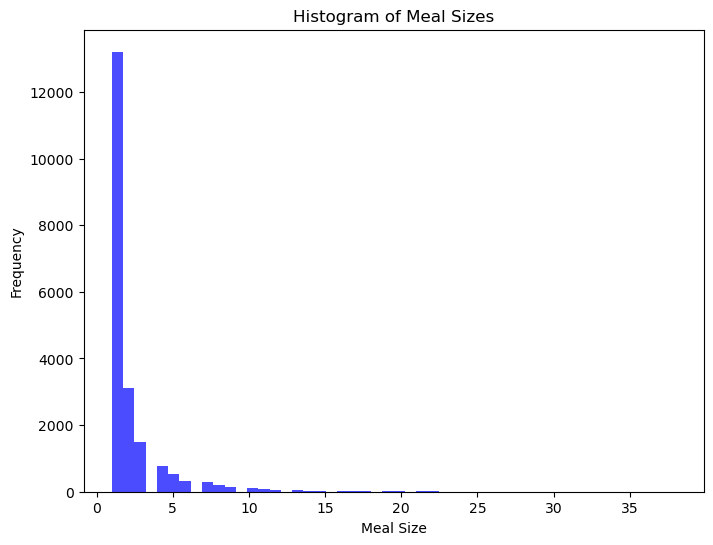

In [3]:
meal_sizes = []

for run in range(1,repetitions+1):
    run_dir = f"{folder}/run_{str(run).zfill(3)}"
    meal_sizes.extend(np.load(f"{run_dir}/meal_sizes.npy"))

meal_sizes = [meal for meal in meal_sizes if meal > 0]

plt.figure(figsize=(8, 6))
plt.hist(meal_sizes, bins=50, density=False, color='blue', alpha=0.7)
plt.xlabel('Meal Size')
plt.ylabel('Frequency')
plt.title('Histogram of Meal Sizes')
plt.show()

### Fit powerlaw (using Powerlaw package)

Calculating best minimal value for power law fit


Estimated alpha: 6.475563504634216
Log-likelihood ratio: 1.092454229203121
P-value for comparison: 0.27428980188550944
Exponential fit is as good or better than power law fit


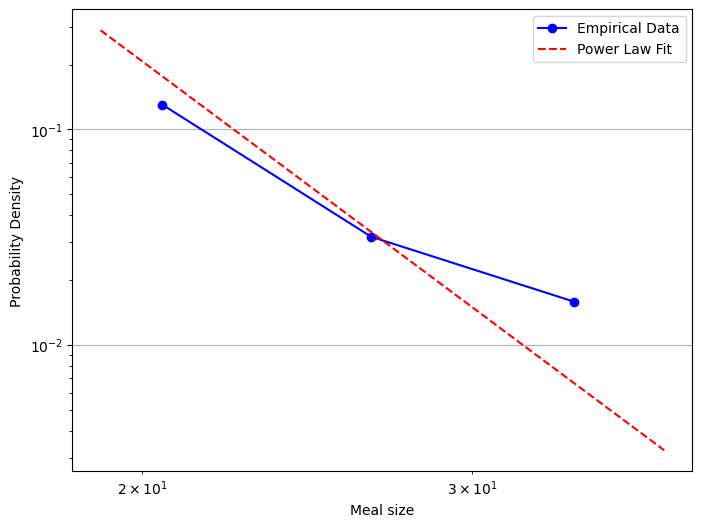

In [4]:
fit = powerlaw.Fit(meal_sizes)

alpha = fit.alpha
print(f"Estimated alpha: {alpha}")

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio: {R}")
print(f"P-value for comparison: {p}")
    
if p < 0.05:
    print("Power law fit is better than exponential fit")
else:
    print("Exponential fit is as good or better than power law fit")

plt.figure(figsize=(8, 6))
fit.plot_pdf(color='blue', linestyle='-', marker='o', label='Empirical Data')
fit.power_law.plot_pdf(color='red', linestyle='--', label='Power Law Fit')
plt.xlabel("Meal size")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

### Fit powerlaw (using Arran's code)

In [5]:
def powerlaw_fit(X, Y):
    slope, y_intercept = np.polyfit(
        np.log(X),
        np.log(Y),
        deg=1
    )

    a = np.exp(y_intercept)
    b = slope

    return a, b

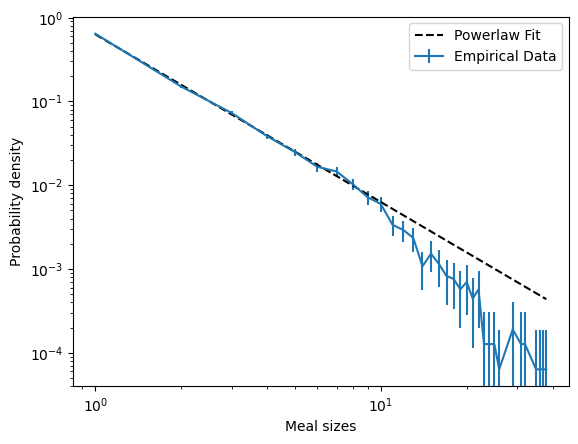

In [7]:
folder = '../simulation_results/'

Y = np.array([], dtype=int)

for file in os.listdir(folder)[1:]:
    Y = np.concatenate([
        Y, 
        np.load(folder + file + '/meal_sizes.npy')
    ])

Y = Y[Y > 0]

N = len(Y)
Y_unique, Y_freq = np.unique(Y, return_counts=True)
Y_freq = Y_freq / N
Y_err = 1.96 * np.sqrt(Y_freq * (1 - Y_freq) / N)

X_fit = Y_unique[:9]
Y_fit = Y_freq[:9]

a, b = powerlaw_fit(X_fit, Y_fit)

Y_pred = a * Y_unique ** b

fig, ax = plt.subplots()

ax.errorbar(
    Y_unique,
    Y_freq,
    yerr=Y_err,
    label='Empirical Data'
)
ax.plot(Y_unique, Y_pred, label='Powerlaw Fit', color='black', linestyle='--')
ax.loglog()
ax.set_xlabel("Meal sizes")
ax.set_ylabel("Probability density")
ax.legend()
plt.show()